In [1]:
import sys
import pandas as pd
import math
import argparse
import vcf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

<h2>Figure 1</h2>

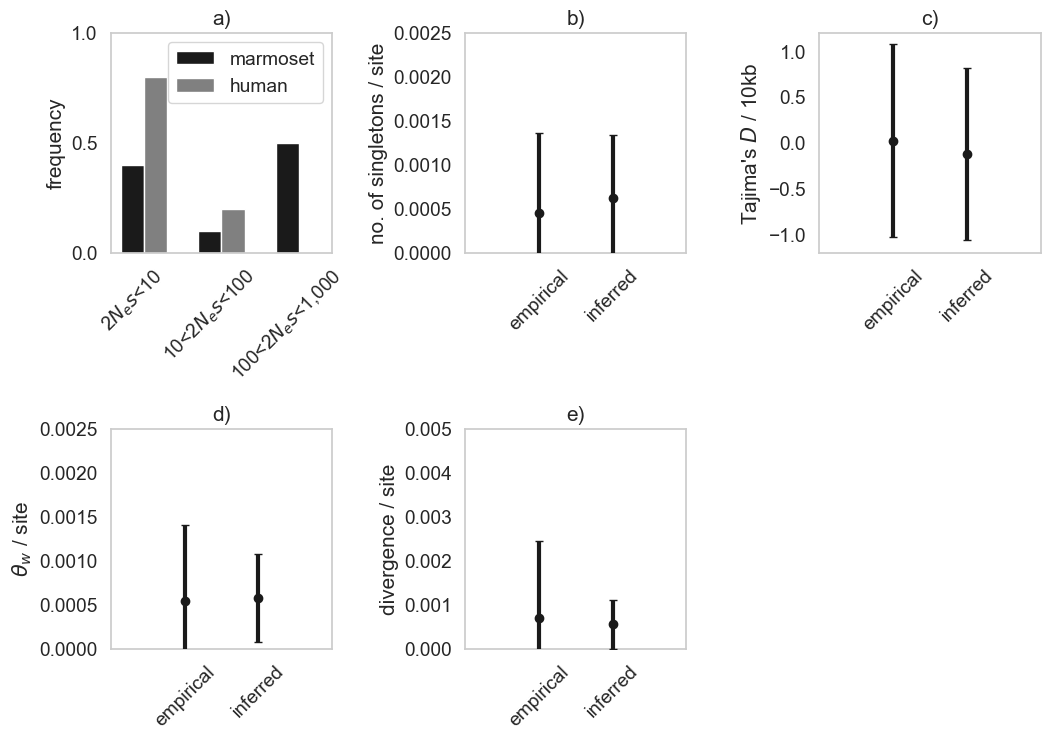

In [14]:
#function reads through .fixed file, 
def get_divergence(f_fixed, chr_len, burnIn=61198 * 10):
    #Load in fixed file
    fixed = pd.read_csv(f_fixed, skiprows=2, sep=' ',
           names=['tempID', 'permID', 'mutType', 'physPos', 's', 'h', 'initial_subpop', 'origin_gen', 'fix_gen'])
    #Remove mutations that fixed during burn-in (ie before divergence phase)
    fixed = fixed[(fixed.fix_gen>burnIn)]
    #Return divergence
    div = len(fixed) / chr_len
    return(div)


t_list = ['a)', 'b)', 'c)','d)','e)']

edf = pd.read_csv(r"DFE_inference/empirical_exonic.stats", sep='\t', header=0)
lst = []
lst2 = []
sdf = pd.DataFrame()
sdf2 = pd.DataFrame()
for i in range(0, 100):
    try:
        f_fixed = r"DFE_inference/simulated_stats/bestFit_rep" + str(i) + ".fixed"
        lst2.append(get_divergence(f_fixed=f_fixed, chr_len=3209))
    except Exception:
        pass

    try:
        df = pd.read_csv(r"DFE_inference/simulated_stats/bestFit_rep" + str(i) + "_chimeric.stats", sep='\t', header=0)
        sdf2 = pd.concat([sdf2,df])
    except Exception:
        pass

titles = ['no. of singletons / site', r"Tajima's $D$ / 10kb", r'$\theta_w$ / site']

ylims = [[0,0.0025], [-1.2, 1.2], [0,0.0025]]
sns.set(rc={'figure.figsize':(12, 8),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
plt.subplot(2,3,1)
DFE = [0.4,0.1,0.5]
DFE2 = [0.8,0.2,0]
DFE_x = [a for a in range(0,3)]
plt.bar(x=DFE_x, height=DFE, color='k', width=0.3, label='marmoset')
plt.bar(x=[x+0.3 for x in DFE_x], height=DFE2, color='grey', width=0.3, label='human')
plt.ylabel('frequency')
plt.xticks(DFE_x, [r'2$N_es$<10', r'10<2$N_es$<100', r'100<2$N_es$<1,000'], rotation=45) 
#plt.xticklabels([r'2$N_es$<10', r'10<2$N_es$<100', r'100<2$N_es$<1,000'], rotation=45)
plt.yticks([0, 0.5, 1])
plt.title(t_list[0])
plt.legend()

for i,stat in enumerate(['numsingletons', 'tajimasd', 'thetaw']):
    plt.subplot(2,3,i+2)
    plt.errorbar([0.95], edf[stat].mean(), edf[stat].std(),
                        fmt='o', lw=3, capsize=3, zorder=15, c='k', label='empirical')

    plt.errorbar([1], sdf2[stat].mean(), sdf2[stat].std(),
                        fmt='o', lw=3, capsize=3, zorder=15, c='k', label='simulated')
    
    plt.ylim(ylims[i])
    plt.xticks([0.9, 0.95, 1, 1.05],['','empirical', 'inferred',''], rotation=45)
    plt.ylabel(titles[i])
    plt.title(t_list[i+1])
        

plt.subplot(2,3,5)
plt.errorbar([0.95], edf['divergence'].mean(), edf['divergence'].std(),
                    fmt='o', lw=3, capsize=3, zorder=15, c='k', label='empirical')

plt.errorbar([1], np.mean(lst2), np.std(lst2),
                    fmt='o', lw=3, capsize=3, zorder=15, c='k', label='simulated')

plt.ylabel('divergence / site')
plt.xticks([0.9, 0.95, 1, 1.05],['','empirical', 'inferred',''], rotation=45)
plt.ylim([0, 0.005])
plt.title(t_list[-1])
#plt.legend()
plt.subplots_adjust(wspace=0.6, hspace=0.8)

<h2>Figure 2</h2>

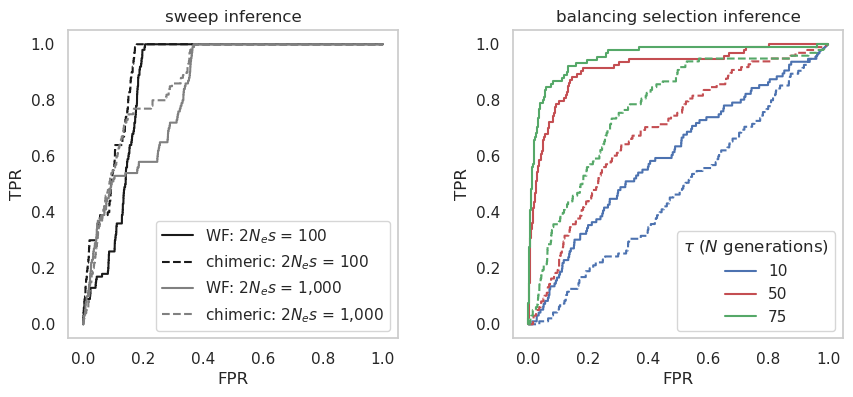

In [14]:
chr_len = 911610
gen=0.01
winSize=1000

cl = ['b','r','g']
nlist = ['100', '1,000']

sns.set(rc={'figure.figsize':(10,4),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1)

rdf = pd.DataFrame() 
rdf2 = pd.DataFrame()
lst = [1, 4, 7]
cl = ['k','grey']
plt.subplot(1,2,1)
for n, N in enumerate(['100', '1000']): 
    rdf = pd.DataFrame() 
    rdf2 = pd.DataFrame()
    for rep in range(1, 101):
        df = pd.read_csv(r"power_analysis/equilibrium/SF2_output/" + str(gen) + "_"+N+"_rep"
                                  + str(rep) + "_WF.out", sep='\t', header=0)
        df['bin'] = pd.cut(df.location, [x for x in range(1, chr_len+winSize, winSize)],
                                  labels=[x for x in range(1, chr_len, winSize)])
        #sweep at position 37,336
        sweep = ((int(math.ceil(455870 / winSize)) - 1) * winSize) + 1
        df['sweep'] = np.where(df.bin == sweep, 1, 0)
        df = df.sort_values('LR', ascending=False).drop_duplicates('bin').sort_index()
        rdf = pd.concat([rdf, df])

        df = pd.read_csv(r"power_analysis/equilibrium/SF2_output/" + str(gen) + "_"+N+"_rep"
                                  + str(rep) + "_chimeric.out", sep='\t', header=0)
        df['bin'] = pd.cut(df.location, [x for x in range(1, chr_len+winSize, winSize)],
                                  labels=[x for x in range(1, chr_len, winSize)])
        #sweep at position 37,336
        sweep = ((int(math.ceil(455870 / winSize)) - 1) * winSize) + 1
        df['sweep'] = np.where(df.bin == sweep, 1, 0)
        df = df.sort_values('LR', ascending=False).drop_duplicates('bin').sort_index()
        rdf2 = pd.concat([rdf2, df])
        
        
        
    fpr, tpr, thresholds = metrics.roc_curve(rdf.sweep, rdf.LR)
    plt.plot(fpr, tpr, c=cl[n], label='WF: ' + r"2$N_es$ = " + nlist[n])

    fpr, tpr, thresholds = metrics.roc_curve(rdf2.sweep, rdf2.LR)
    plt.plot(fpr, tpr, c=cl[n], label='chimeric: ' + r"2$N_es$ = " + nlist[n], linestyle='--')    
plt.title('sweep inference')
    
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')

chr_len = 91161
winSize=100
rep=1
cl = ['b','r','g']
plt.subplot(1,2,2)
rdf = pd.DataFrame() 
rdf2 = pd.DataFrame()
for t,T in enumerate(['10','50','75']):
    rdf = pd.DataFrame() 
    rdf2 = pd.DataFrame()
    for rep in range(1, 101):
        try:
            df = pd.read_csv(r"power_analysis/equilibrium/BM_output/" + T + "N_rep"
                                      + str(rep) + "_WF.out", sep='\t', header=0)
            df['bin'] = pd.cut(df.physPos, [x for x in range(1, chr_len+winSize, winSize)],
                                      labels=[x for x in range(1, chr_len, winSize)])
            #sweep at position 37,336
            sweep = ((int(math.ceil(37337 / winSize)) - 1) * winSize) + 1
            df['sweep'] = np.where(df.bin == sweep, 1, 0)
            df = df.sort_values('CLR', ascending=False).drop_duplicates('bin').sort_index()
            rdf = pd.concat([rdf, df])
        except Exception:
            pass
        try:
            df = pd.read_csv(r"power_analysis/equilibrium/BM_output/" + T + "N_rep"
                                      + str(rep) + "_chimeric.out", sep='\t', header=0)
            df['bin'] = pd.cut(df.physPos, [x for x in range(1, chr_len+winSize, winSize)],
                                      labels=[x for x in range(1, chr_len, winSize)])
            #sweep at position 37,336
            sweep = ((int(math.ceil(37337 / winSize)) - 1) * winSize) + 1
            df['sweep'] = np.where(df.bin == sweep, 1, 0)
            df = df.sort_values('CLR', ascending=False).drop_duplicates('bin').sort_index()
            rdf2 = pd.concat([rdf2, df])
        except Exception:
            pass
        
    fpr, tpr, thresholds = metrics.roc_curve(rdf.sweep, rdf.CLR)
    fpr2, tpr2, thresholds2 = metrics.roc_curve(rdf2.sweep, rdf2.CLR)

    plt.plot(fpr, tpr, c=cl[t], label=T)
    plt.plot(fpr2, tpr2, c=cl[t], linestyle='--')
plt.legend(title=r'$\tau$ ($N$ generations)')
plt.title('balancing selection inference')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.subplots_adjust(wspace=0.35, hspace=0.45)


<h2>Figure 3</h2>

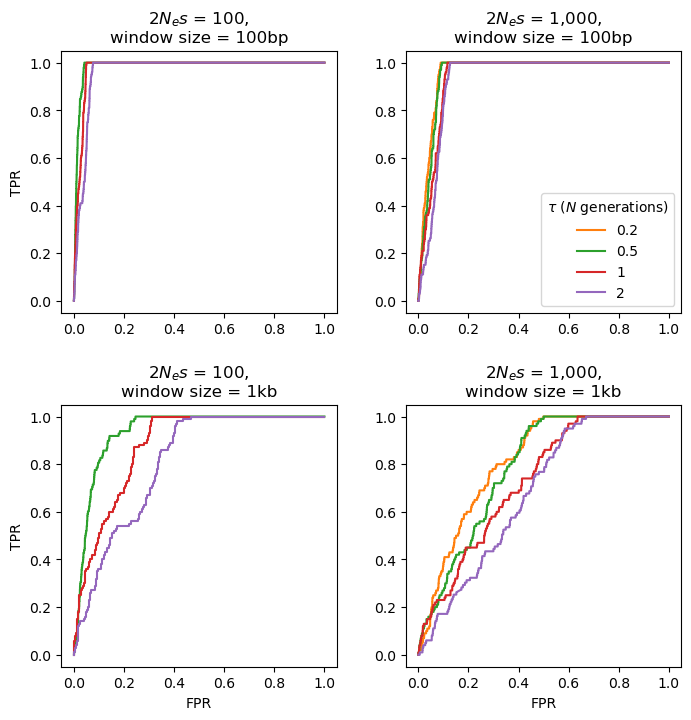

In [4]:
cols = ['tab:blue',
'tab:orange',
'tab:green',
'tab:red',
'tab:purple',
'tab:brown',
'tab:pink',
'tab:gray',
'tab:olive',
'tab:cyan']

labs = ['100bp', '1kb']

fig, axs = plt.subplots(2, 2, figsize=(8,8))
chr_len=91161

for i, gen in enumerate([0.5, 1, 2]):
    rdf = [pd.DataFrame() for x in range(0, 2)] 
    for rep in range(1, 101):
        for w, winSize in enumerate([100, 1000]):
            try:
                df = pd.read_csv(r"power_analysis/marmoset_demog/SF2_output/" + str(gen) + "_100_rep"
                                          + str(rep) + "_marm_pa.out", sep='\t', header=0)
                df['bin'] = pd.cut(df.location, [x for x in range(1, chr_len+winSize, winSize)],
                                          labels=[x for x in range(1, chr_len, winSize)])
                #sweep at position 37,336
                sweep = ((int(math.ceil(37336 / winSize)) - 1) * winSize) + 1
                df['sweep'] = np.where(df.bin == sweep, 1, 0)
                df1 = pd.DataFrame(df.groupby('bin', observed=False)['sweep'].sum())
                df2 = pd.DataFrame(df.groupby('bin', observed=False)['LR'].max())
                df = pd.merge(df1,df2, left_index=True, right_index=True)
                df['LR'] = np.where(df.LR.isna(), 0, df.LR)
                df['sweep'] = np.where(df.sweep > 1, 1, df.sweep)
                rdf[w] = pd.concat([rdf[w], df])
            except Exception:
                pass
    for r, df in enumerate(rdf):
        y = df.sweep
        scores = df.LR
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        axs[r,0].plot(fpr, tpr, label=str(gen), c=cols[i+2]) 
        axs[r,0].set_title("$2N_es$" + " = 100,\nwindow size = " + str(labs[r]))
        axs[r,0].set_ylabel("TPR")
    axs[1,0].set_xlabel("FPR")
    
    
for i, gen in enumerate([0.2, 0.5, 1, 2]):
    rdf = [pd.DataFrame() for x in range(0, 2)] 
    for rep in range(1, 101):
        for w, winSize in enumerate([100, 1000]):
            try:
                df = pd.read_csv(r"power_analysis/marmoset_demog/SF2_output/" + str(gen) + "_1000_rep"
                                          + str(rep) + "_marm_pa.out", sep='\t', header=0)
                df['bin'] = pd.cut(df.location, [x for x in range(1, chr_len+winSize, winSize)],
                                          labels=[x for x in range(1, chr_len, winSize)])
                #sweep at position 37,336
                sweep = ((int(math.ceil(37336 / winSize)) - 1) * winSize) + 1
                df['sweep'] = np.where(df.bin == sweep, 1, 0)
                df1 = pd.DataFrame(df.groupby('bin', observed=False)['sweep'].sum())
                df2 = pd.DataFrame(df.groupby('bin', observed=False)['LR'].max())
                df = pd.merge(df1,df2, left_index=True, right_index=True)
                df['LR'] = np.where(df.LR.isna(), 0, df.LR)
                df['sweep'] = np.where(df.sweep > 1, 1, df.sweep)
                rdf[w] = pd.concat([rdf[w], df])
            except Exception:
                pass
    for r, df in enumerate(rdf):
        y = df.sweep
        scores = df.LR
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        axs[r,1].plot(fpr, tpr, label=str(gen), c=cols[i+1]) 
        axs[r,1].set_title("$2N_es$" + " = 1,000,\nwindow size = " + str(labs[r]))
    axs[1,1].set_xlabel("FPR")
    

        
axs[0,1].legend(title=r'$\tau$' + ' (' + '$N$' +  ' generations)')
plt.subplots_adjust(wspace=0.25, hspace=0.35)

<h2>Figure 4</h2>

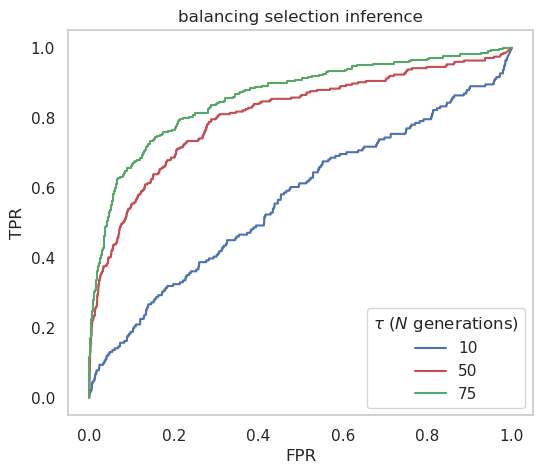

In [6]:
chr_len = 91161
gen=0.01
winSize=1000
rep=1

cl = ['b','r','g']
nlist = ['100', '1,000']

sns.set(rc={'figure.figsize':(6,5),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1)

chr_len = 91161
winSize=100
rep=1
cl = ['b','r','g']
rdf = pd.DataFrame() 
rdf2 = pd.DataFrame()
for t,T in enumerate(['10','50', '75']):
    rdf = pd.DataFrame() 
    for rep in range(1, 101):
        try:
            df = pd.read_csv(r"power_analysis/marmoset_demog/BM_output/" + T + "_rep"
                                      + str(rep) + "_marm_pa_1kb.out", sep='\t', header=0)
            df['bin'] = pd.cut(df.physPos, [x for x in range(1, chr_len+winSize, winSize)],
                                      labels=[x for x in range(1, chr_len, winSize)])
            lst = list(df.physPos)
            df['bp'] = [1 if((x-500)<37337) & ((x+500)>37337) else 0 for x in lst]

            rdf = pd.concat([rdf, df])
        except Exception:
            pass
        
    fpr, tpr, thresholds = metrics.roc_curve(rdf.bp, rdf.CLR)

    plt.plot(fpr, tpr, c=cl[t], label=T)
plt.legend(title=r'$\tau$ ($N$ generations)')
plt.title('balancing selection inference')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.subplots_adjust(wspace=0.35, hspace=0.45)

<h2>Figure 5</h2>

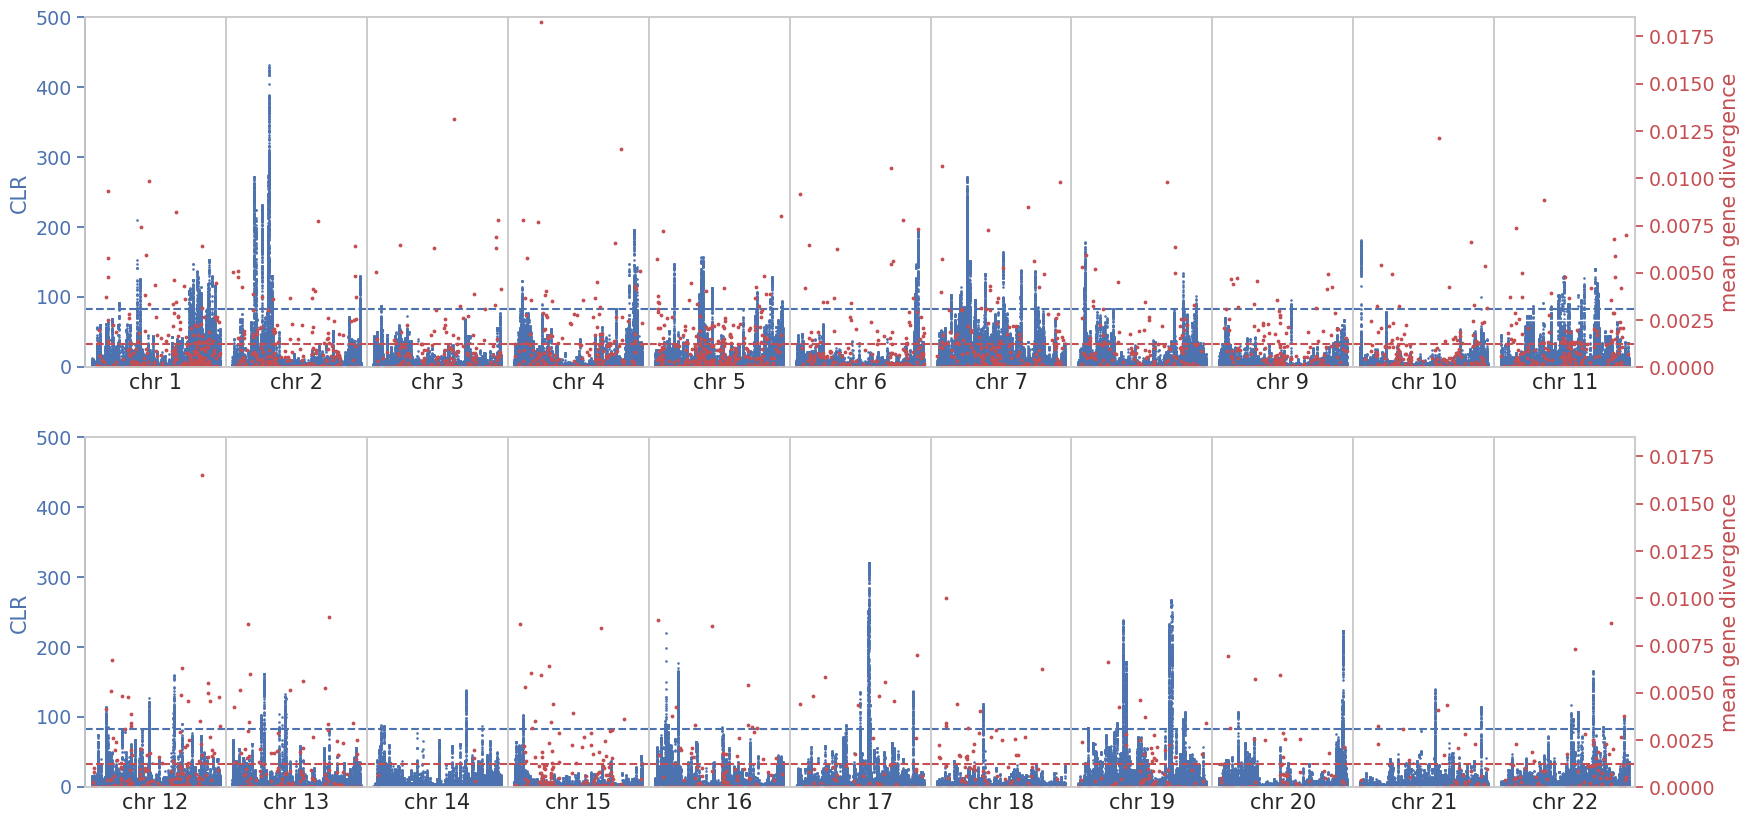

In [7]:
ddf = pd.read_csv(r"empirical_scans/mean_gene_divergence.txt", sep='\t', header=0)
                  sep='\t', names=['chrom','start','end','length', 'mutations', 'divergence'])

peak_df = pd.DataFrame()
sns.set(rc={'figure.figsize':(20,10),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
fig, axs = plt.subplots(2,11)
for i,j in enumerate([x for x in range(42,53)]):
    df = pd.read_csv(r"empirical_scans/SF2_results/ALL_NC_0714"+ str(j) + "_noFix.out", sep='\t', header=0)
    tdf = ddf[ddf.chrom=="NC_0714"+str(j)+".1"]
    axs[0,i].scatter(x=df.location, y=df['LR'], s=0.75)
    axs[0,i].axhline(maxes['sf'], color='b', linestyle='--')
    axs[0,i].set_xticks([])
    axs[0,i].set_ylim([-1, 500])
    if(j==42):
        axs[0,i].set_ylabel('CLR', color='b')
        axs[0,i].tick_params(axis='y', colors='b')
        axs[0,i].spines['left'].set_color('b')
    #    plt.text(s='Null threshold', x=0, y=maxes['100nt']+10)
    else:
        axs[0,i].set_yticks([])
    axs[0,i].set_xlabel('chr ' + str(j-41))
    df = df[df.LR>=maxes['sf']]
    df['scaffold'] = 'NC_0714' + str(i)
    peak_df = pd.concat([peak_df, df])
    ax2 = axs[0,i].twinx()
    ax2.scatter(x=tdf.start, y=tdf.divergence, color='r', s=3)
    ax2.axhline(0.001263, color='r', linestyle='--')
    ax2.set_ylim([0, 0.0185])
    if(j==52):
        ax2.set_ylabel('mean gene divergence', color='r')
        ax2.tick_params(axis='y', colors='r')
        #ax2.spines['right'].set_color('r')
    #    plt.text(s='Null threshold', x=0, y=maxes['100nt']+10)
    else:
        ax2.set_yticks([])
        
        
for i,j in enumerate([x for x in range(53,64)]):
    df = pd.read_csv(r"empirical_scans/SF2_results/ALL_NC_0714"+ str(j) + "_noFix.out", sep='\t', header=0)
    tdf = ddf[ddf.chrom=="NC_0714"+str(j)+".1"]
    axs[1,i].scatter(x=df.location, y=df['LR'], s=0.75)
    axs[1,i].axhline(maxes['sf'], color='b', linestyle='--')
    axs[1,i].set_xticks([])
    axs[1,i].set_ylim([-1, 500])
    if(j==53):
        axs[1,i].set_ylabel('CLR', color='b')
        axs[1,i].tick_params(axis='y', colors='b')
        axs[1,i].spines['left'].set_color('b')
    else:
        axs[1,i].set_yticks([])
    axs[1,i].set_xlabel('chr ' + str(j-41))
    df = df[df.LR>=maxes['sf']]
    df['scaffold'] = 'NC_0714' + str(i)
    peak_df = pd.concat([peak_df, df])
    ax2 = axs[1,i].twinx()
    ax2.scatter(x=tdf.start, y=tdf.divergence, color='r', s=3)
    ax2.axhline(0.001263, color='r', linestyle='--')
    ax2.set_ylim([0, 0.0185])
    if(j==63):
        ax2.set_ylabel('mean gene divergence', color='r')
        ax2.tick_params(axis='y', colors='r')
        #ax2.spines['right'].set_color('r')
    #    plt.text(s='Null threshold', x=0, y=maxes['100nt']+10)
    else:
        ax2.set_yticks([])
    
plt.subplots_adjust(wspace=0, hspace=0.2)

<h2>Figure 6</h2>

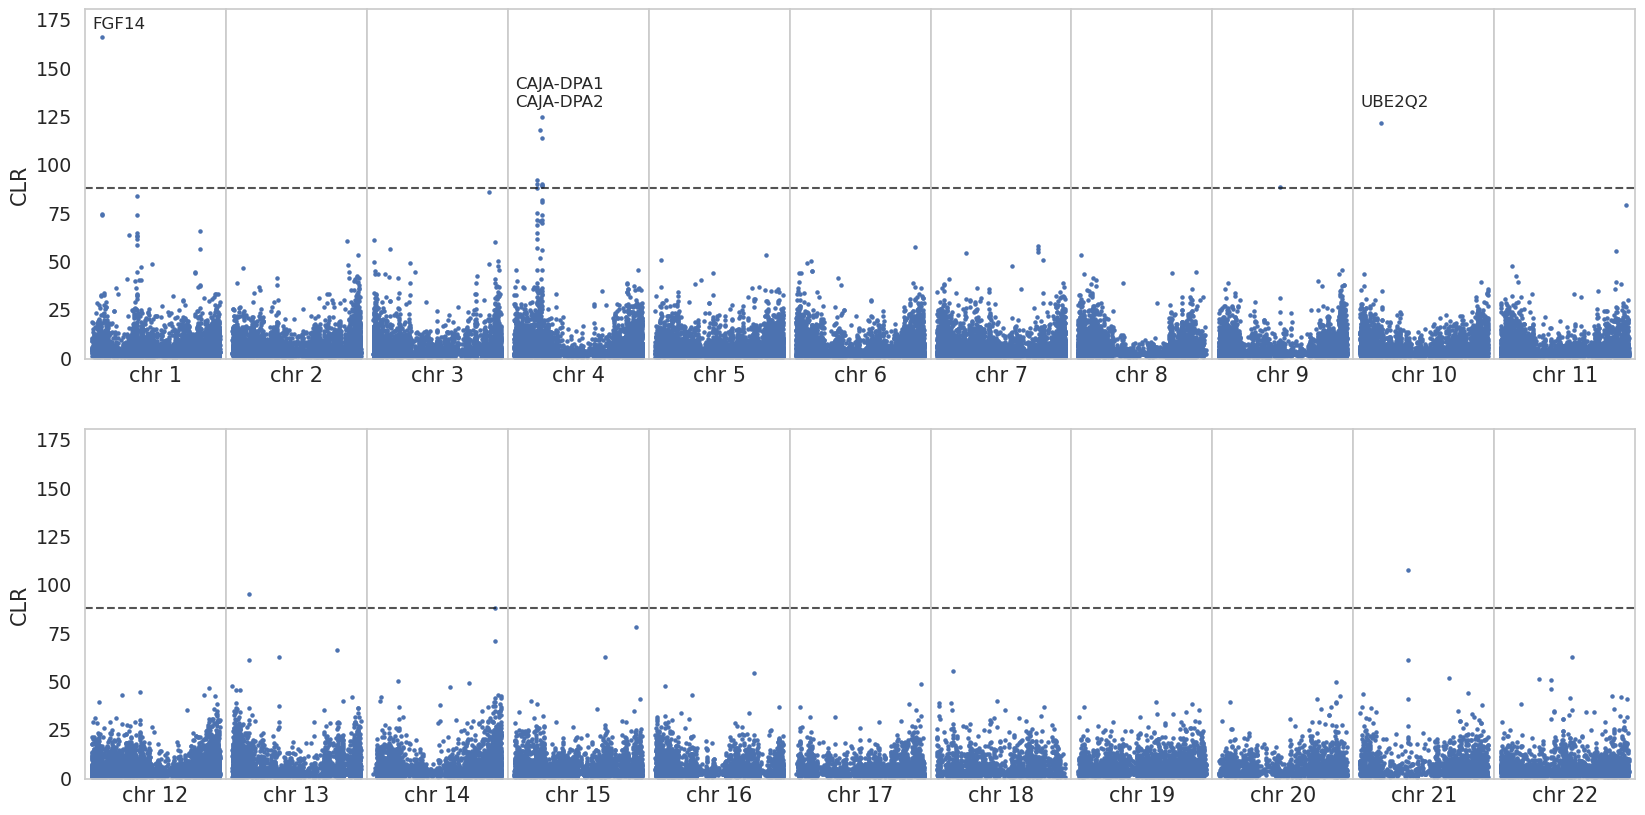

In [9]:
peak_df = pd.DataFrame()
sns.set(rc={'figure.figsize':(20,10),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
for i in range(42,53):
    df = pd.read_csv(r"empirical_scans/BM_results/ALL_NC_0714"+ str(i) + "_1kb.out", sep='\t', header=0)
    plt.subplot(2,11,i-41)
    plt.scatter(x=df.physPos, y=df['CLR'], s=5)
    plt.axhline(maxes['1kb'], color='k', linestyle='--', alpha=0.75)
    plt.xticks([])
    plt.ylim([-1, 180])
    if(i==42):
        plt.ylabel('CLR')
        plt.text(s='FGF14', x=2000000, y=170, size=12)
    #    plt.text(s='Null threshold', x=0, y=maxes['100nt']+10)
    else:
        plt.yticks([])
    plt.xlabel('chr ' + str(i-41))
    
    if(i==45):
        plt.text(s='CAJA-DPA1\nCAJA-DPA2', x=2000000, y=130, size=12)
    if(i==51):
        plt.text(s='UBE2Q2', x=500000, y=130, size=12)
        
for i in range(53,64):
    df = pd.read_csv(r"empirical_scans/BM_results/ALL_NC_0714"+ str(i) + "_1kb.out", sep='\t', header=0)
    plt.subplot(2,11,i-41)
    plt.scatter(x=df.physPos, y=df['CLR'], s=5)
    plt.axhline(maxes['1kb'], color='k', linestyle='--', alpha=0.75)
    plt.xticks([])
    plt.ylim([-1, 180])
    if(i==53):
        plt.ylabel('CLR')
        #plt.text(s='Null threshold', x=0, y=maxes['100nt']+10)
    else:
        plt.yticks([])
    plt.xlabel('chr ' + str(i-41))
    
    if(i==51):
        plt.text(s='UBE2Q2', x=500000, y=130, size=12)
